In [0]:
""" This notebook contains code for computing norms and sharpness values for SGD
Results are averaged over 3 random seeds to minimize the variation"""

%tensorflow_version 2.x
import tensorflow as tf
device = tf.test.gpu_device_name()
if device != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device))

from google.colab import drive
drive.mount('/content/drive')


%cd /content/drive/My Drive/Colab Notebooks

In [0]:
# Importing Libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import argparse, copy

from model import *
from utils import *
from measures import *

In [0]:
"""We do a grid search over the learning rates. 
We chose learning rate with the lowest validation loss.
Results are averaged over 3 random seeds to minimize the variation."""

validation_losses = []
seeds = [12345, 1234, 123]
for seed in seeds:
    print ("seed:::", seed)
    torch.manual_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model Hyperparamters
    batch_size = 64
    epochs = 14
    lrs = [1e-1,3e-2, 3e-3, 3e-4, 3e-5]  
    gamma = 0.7
    momentum = 0.0

    use_cuda = torch.cuda.is_available()
    train_loader, val_loader, test_loader, train_size, val_size = dataloaders(batch_size, use_cuda, seed)
    print (train_size, val_size, len(test_loader.dataset))

    model = Net().to(device)
    
    # Grid Search over different learning rates - over validation dataset
    val_losses = []
    for lr in lrs:
        print ("lr:", lr)
        model_copy = copy.deepcopy(model)
        optimizer = optim.SGD(model_copy.parameters(), lr=lr,momentum=momentum)
        scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

        for epoch in range(1, epochs + 1):
            train_loss = train(model_copy, device, train_loader, optimizer, epoch, batch_size)
            val_loss = test_2(model_copy, device, val_loader, batch_size, val_size)
            # test_loss = test(model_copy, device, test_loader, batch_size)  # one can see on test_loss as well.....
            scheduler.step()
        val_losses.append(val_loss)
    validation_losses.append(val_losses)  

seed::: 12345
54000 6000 10000
lr: 0.1

Test set: Average loss: 0.1268, Accuracy: 5773/6000 (96%)


Test set: Average loss: 0.0979, Accuracy: 5821/6000 (97%)


Test set: Average loss: 0.0824, Accuracy: 5849/6000 (97%)


Test set: Average loss: 0.0755, Accuracy: 5867/6000 (98%)


Test set: Average loss: 0.0698, Accuracy: 5877/6000 (98%)


Test set: Average loss: 0.0691, Accuracy: 5876/6000 (98%)


Test set: Average loss: 0.0683, Accuracy: 5879/6000 (98%)


Test set: Average loss: 0.0676, Accuracy: 5882/6000 (98%)


Test set: Average loss: 0.0676, Accuracy: 5885/6000 (98%)


Test set: Average loss: 0.0677, Accuracy: 5887/6000 (98%)


Test set: Average loss: 0.0677, Accuracy: 5888/6000 (98%)


Test set: Average loss: 0.0673, Accuracy: 5885/6000 (98%)


Test set: Average loss: 0.0674, Accuracy: 5885/6000 (98%)


Test set: Average loss: 0.0675, Accuracy: 5885/6000 (98%)

lr: 0.03

Test set: Average loss: 0.4805, Accuracy: 4979/6000 (83%)


Test set: Average loss: 0.4190, Accuracy: 5105/6000

In [0]:
print (validation_losses)

#averaging validation losses over different seeds
validation_losses = np.mean(np.array(validation_losses), 0)
print (validation_losses)

[[0.06750706250363207, 0.3627114435459705, 0.5767602432281413, 1.868920846188322, 2.2779094361244363], [0.057734508939245914, 0.11157345256589829, 0.34650322414459067, 1.7501160439024581, 2.2666120148719626], [0.06273035383089742, 0.10653857201179291, 0.3286040496635944, 1.7587670721906297, 2.268179898566388]]
[0.06265731 0.19360782 0.41728917 1.79260132 2.27090045]


'best lr = 3e-6 in case of RMSprop'

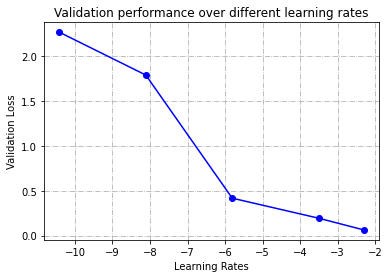

In [0]:
# Learning Rates - ['1e-1', '3e-2', '3e-3', '3e-4', '3e-5']   plotted on log scale
lr_rates = np.log(np.array(lrs))

fig = plt.figure()
plt.plot(lr_rates, validation_losses, color='blue', marker='o') 
plt.xlabel('Learning Rates')
plt.ylabel('Validation Loss')
plt.title("Validation performance over different learning rates")
plt.grid(True, linestyle='-.')
fig.show()   

"""best lr = 1e-1 in case of SGD"""

"""please ignore the below line"""

In [0]:
# Results averaged over 3 different random seeds
avg_train_losses, avg_test_losses, avg_difference_test_train = [], [], []
avg_weight_norms_list, avg_sharpness_list, avg_std_list, avg_mean_list = [], [], [], []

seeds = [12345, 1234, 123]
for seed in seeds:
    print ("seed:::", seed)
    torch.manual_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model Hyperparamters
    batch_size = 64
    epochs = 14
    lr = 1e-1 # lowest validation loss
    gamma = 0.7
    momentum = 0.0

    use_cuda = torch.cuda.is_available()
    train_loader, val_loader, test_loader, train_size, val_size = dataloaders(batch_size, use_cuda, seed)
    print (train_size, val_size, len(test_loader.dataset))

    model = Net().to(device)

    train_losses, test_losses = [], []
    sigmas = [0.001,0.003,0.006,0.009,0.03,0.06,0.09]    
    delta = 1e-2
    mean = 0.0
    weight_norms_list = []
    sharpness_list = []

    optimizer = optim.SGD(model.parameters(), lr=lr,momentum=momentum)  
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

    for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch, batch_size)
        train_losses.append(train_loss)
        test_loss = test(model, device, test_loader, batch_size)
        test_losses.append(test_loss)
        scheduler.step()
    
    avg_train_losses.append(train_losses) 
    avg_test_losses.append(test_losses)

    # print train and test losses and their difference
    difference_test_train = np.array(test_losses)  - np.array(train_losses)
    avg_difference_test_train.append(difference_test_train)

    print ("running for sigmas")
    """run for each sigma"""
    std_list = []
    mean_list = []

    for sigma in sigmas:
        weight_l2_norm = cal_l2_norm(model)
        weight_bound = compute_bound(model, train_size, sigma, weight_l2_norm, delta)  
        weight_norms_list.append(weight_bound)

        #to calculate sharpness, perturb the same model 20 times, then get expected value
        num_times = 20
        p_train_losses = []
        for iterate in range(num_times):
            p_model = copy.deepcopy(model)
            p_model = weight_pertubation(p_model, mean, sigma, device)
            p_train_loss = test_2(p_model, device, train_loader, batch_size, train_size)
            p_train_losses.append(p_train_loss)
        exp_p_error = sum(p_train_losses) / len(p_train_losses)
        std_list.append(np.std(np.array(p_train_losses)))
        mean_list.append(np.mean(np.array(p_train_losses)))

        sharpness = exp_p_error - train_loss
        sharpness_list.append(sharpness)
    
    avg_weight_norms_list.append(weight_norms_list)
    avg_sharpness_list.append(sharpness_list)
    avg_std_list.append(std_list)
    avg_mean_list.append(mean_list)

seed::: 12345
54000 6000 10000

Test set: Average loss: 0.1154, Accuracy: 9650/10000 (96%)


Test set: Average loss: 0.0849, Accuracy: 9725/10000 (97%)


Test set: Average loss: 0.0704, Accuracy: 9777/10000 (98%)


Test set: Average loss: 0.0660, Accuracy: 9791/10000 (98%)


Test set: Average loss: 0.0633, Accuracy: 9801/10000 (98%)


Test set: Average loss: 0.0599, Accuracy: 9810/10000 (98%)


Test set: Average loss: 0.0596, Accuracy: 9809/10000 (98%)


Test set: Average loss: 0.0600, Accuracy: 9805/10000 (98%)


Test set: Average loss: 0.0597, Accuracy: 9812/10000 (98%)


Test set: Average loss: 0.0588, Accuracy: 9811/10000 (98%)


Test set: Average loss: 0.0591, Accuracy: 9811/10000 (98%)


Test set: Average loss: 0.0585, Accuracy: 9808/10000 (98%)


Test set: Average loss: 0.0587, Accuracy: 9809/10000 (98%)


Test set: Average loss: 0.0595, Accuracy: 9810/10000 (98%)

running for sigmas

Test set: Average loss: 0.0178, Accuracy: 53838/54000 (100%)


Test set: Average loss: 0.0178, 

In [0]:
print (avg_train_losses)
print (avg_test_losses)
print (avg_difference_test_train)
print (avg_weight_norms_list)
print (avg_sharpness_list)
print (avg_std_list)

[[0.3218057899298897, 0.09338963007051233, 0.059108854547888924, 0.04186348067773109, 0.03236482495009475, 0.026854327297217755, 0.023459365329886146, 0.021460677423708635, 0.020100628913013854, 0.019274000746586417, 0.01868013421214799, 0.018271466112426388, 0.017990187419604915, 0.0178025449974842], [0.27291220311357933, 0.09149384404139779, 0.0586321710419104, 0.041579399983976834, 0.032021806672462634, 0.026784109483005136, 0.023568512806757154, 0.021487634845289857, 0.020196522333354675, 0.019297577606258092, 0.018745935885059115, 0.01832408460477252, 0.018050461948487324, 0.017868626280136017], [0.2750218566418824, 0.09205132985037368, 0.05808054532864577, 0.04100942844745672, 0.032001427635197394, 0.02655167614167194, 0.023444053796406888, 0.021409498097295587, 0.020111679037706266, 0.019267042054379825, 0.018670054844203206, 0.018312238243693196, 0.01803233839959895, 0.01784848411218815]]
[[0.11540682193864683, 0.08494798551983894, 0.07040871610971773, 0.0659994478723046, 0.063

In [0]:
# Averaging over 3 random seeds
avg_train_losses = np.mean(np.array(avg_train_losses), 0)
avg_test_losses = np.mean(np.array(avg_test_losses), 0)
avg_difference_test_train = np.mean(np.array(avg_difference_test_train), 0)

avg_weight_norms_list = np.mean(np.array(avg_weight_norms_list), 0)
avg_sharpness_list = np.mean(np.array(avg_sharpness_list), 0)
avg_std_list = np.mean(np.array(avg_std_list), 0)
avg_mean_list = np.mean(np.array(avg_mean_list), 0)


# print ("avg_train_losses:::\n", avg_train_losses)
# print ("avg_test_losses:::\n", avg_test_losses)
print ("average difference list::\n", avg_difference_test_train)
print ("avg_weight_norms_list::\n", avg_weight_norms_list)
print ("avg_sharpness_list::\n", avg_sharpness_list)
print ("avg_std_list::\n", avg_std_list)
print ("avg_mean_list::\n", avg_mean_list)


average difference list::
 [-0.17060701 -0.00071821  0.01280009  0.02621644  0.03161998  0.03422483
  0.03672032  0.03844809  0.03970724  0.04077557  0.04065977  0.04102108
  0.04108899  0.04151972]
avg_weight_norms_list::
 [339.79788208 113.26596832  56.63301722  37.75538127  11.3268067
   5.6637214    3.77616723]
avg_sharpness_list::
 [-2.62779633e-05  9.36196857e-04  3.64406216e-03  8.14780047e-03
  2.44025846e-01  4.69307341e+00  1.81752009e+01]
avg_std_list::
 [1.56333026e-05 6.70448801e-05 2.54278636e-04 7.36707026e-04
 7.57101079e-02 1.02481132e+00 4.75095933e+00]
avg_mean_list::
 [1.78136072e-02 1.87760820e-02 2.14839473e-02 2.59876856e-02
 2.61865731e-01 4.71091330e+00 1.81930408e+01]


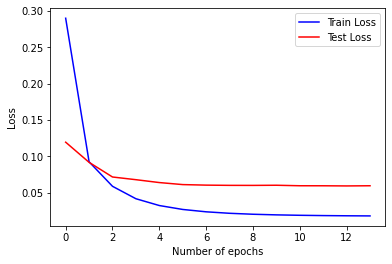

In [0]:
# Plotting training
show_losses(avg_train_losses, avg_test_losses)

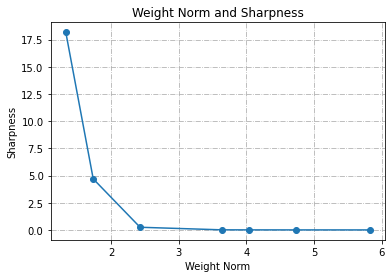

In [0]:
# Plotting Sharpness and Norm term from equation 1 in the report
# Weights are taken on a log scale
plt.plot(np.log(avg_weight_norms_list), avg_sharpness_list, marker='o')
plt.grid(True, linestyle='-.')
plt.title("Weight Norm and Sharpness")
plt.xlabel("Weight Norm")
plt.ylabel("Sharpness")
plt.show()